# 🧪 U-Net 2D
Este notebook usa cortes 2D del dataset de bazo y entrena una U-Net sencilla

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
from scipy.ndimage import zoom
from tensorflow.keras import layers, models
from keras import backend as K
import os, glob, nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score




In [14]:
# NEW: Clear any previous TensorFlow state as I was having issues with GPU memory
import tensorflow as tf
tf.keras.backend.clear_session()

# NEW: Set random seeds for reproducibility
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

In [15]:


def preprocess_image(image, target_size):
    """
    Preprocess a 2D image to match a standard size.

    Parameters:
    - image (numpy.ndarray): The 2D image to preprocess, with shape (X, Y).
    - target_size (tuple): Desired output size as (X, Y).
    Returns:
    - numpy.ndarray: The preprocessed 2D image
    """
    target_x, target_y = target_size
    current_x, current_y = image.shape

    # Rescale in XY dimensions
    scale_y = target_y / current_y
    scale_x = target_x / current_x
    image = zoom(image, (scale_x, scale_y), order=1) # Scale to a common size
    return image



In [16]:

def preprocess_image(slice, target_shape=(128,128)):
    return resize(slice, target_shape, order=1, preserve_range=True).astype(np.float32)

def extract_slices(volume_paths):
  X, Y = [], []
  for img_path in (volume_paths):
    label_path = img_path.replace("imagesTr", "labelsTr")
    img = nib.load(img_path).get_fdata(dtype=np.float32)
    lbl = nib.load(label_path).get_fdata(dtype=np.float32)

    for z in range(img.shape[2]):
        lbl_slice = lbl[:,:,z]
        if np.any(lbl_slice):  # Solo incluir cortes relevantes
            img_prep = preprocess_image(np.rot90(img[:, :, z]))
            lbl_prep = preprocess_image(np.rot90(lbl_slice)).astype(np.uint8)
            X.append(img_prep)
            Y.append(lbl_prep)
  # Convertir a arrays optimizados
  X = np.expand_dims(np.stack(X, axis=0).astype(np.float32), -1)
  Y = np.expand_dims(np.stack(Y, axis=0).astype(np.uint8), -1)
  return X,Y

DATA_PATH = './data'
all_image_paths = sorted(glob.glob(os.path.join(DATA_PATH, "imagesTr", "*.nii.gz")))

X, Y = extract_slices(all_image_paths)

# Normalize the input images to [0,1] range
X = X / 255.0 if X.max() > 1.0 else X
# Ensure labels are binary (0 or 1)
Y = (Y > 0).astype(np.float32)

# División sin mezclar
n_total = len(X)
X_train = X[:20]
Y_train = Y[:20]
X_val = X[20:30]
Y_val = Y[20:30]
X_test = X[30:40]
Y_test = Y[30:40]

# Mostrar tamaños
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)



Training set: (20, 128, 128, 1)
Validation set: (10, 128, 128, 1)
Test set: (10, 128, 128, 1)


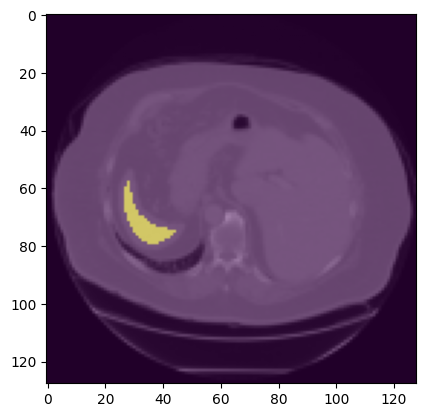

In [17]:
plt.imshow(X_train[10,...,0], cmap='gray')
plt.imshow(Y_train[10,...,0], alpha=0.5)
plt.show()

In [ ]:

# Focal loss function for handling severe class imbalance
# (This was obviusly taken from several iteraction with AI since I was 
# struggling to find a good loss function for this task out of the box)
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate focal loss
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_loss_value = -alpha_t * tf.math.pow((1 - p_t), gamma) * tf.math.log(p_t)
        
        return tf.reduce_mean(focal_loss_value)
    return focal_loss_fixed

# U-Net model
def build_unet(input_shape=(128, 128, 1), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # ------------------------------
    # Encoder (Contracción)
    # ------------------------------
    # Bloque 1
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Bloque 2
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bloque 3
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # ------------------------------
    # Bottleneck (Fondo)
    # ------------------------------
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # ------------------------------
    # Decoder (Expansión)
    # ------------------------------
    # Bloque 1
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.Concatenate()([u5, c3])  # skip connection
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Bloque 2
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    # Bloque 3
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # ------------------------------
    # Capa de salida
    # ------------------------------
    # num_classes=1 → salida binaria (sigmoid)
    # num_classes>1 → salida multiclase (softmax)
    if num_classes == 1:
        output_activation = 'sigmoid'
    else:
        output_activation = 'softmax'

    outputs = layers.Conv2D(num_classes, (1, 1), activation=output_activation)(c7)

    model = models.Model(inputs, outputs)
    return model
# 

model = build_unet()
# Use a lower learning rate for more stable training with focal loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Use focal loss instead of standard loss for handling class imbalance
# Added accuracy as a metric for monitoring performance
model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

Positive class weight: 203.54
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step - accuracy: 0.7281 - loss: 0.0941 - val_accuracy: 0.9972 - val_loss: 0.0084
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 379ms/step - accuracy: 0.9951 - loss: 0.0111 - val_accuracy: 0.9972 - val_loss: 0.0060
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - accuracy: 0.9951 - loss: 0.0039 - val_accuracy: 0.9972 - val_loss: 0.0024
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - accuracy: 0.9951 - loss: 0.0039 - val_accuracy: 0.9972 - val_loss: 0.0034
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.9951 - loss: 0.0027 - val_accuracy: 0.9972 - val_loss: 0.0021
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.9951 - loss: 0.0024 - val_accuracy: 0.9972 - val_loss: 0.0023
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 415ms/step - accuracy: 0.9951 - loss: 0.0022 - val_accuracy: 0.9972 - val_loss: 0.0021
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - accuracy: 0.9951 - l

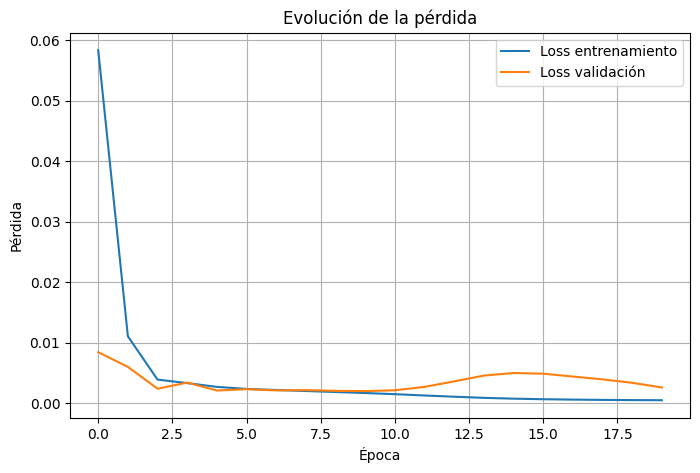

In [19]:
# Entrenamiento
pos_weight = np.sum(Y_train == 0) / np.sum(Y_train == 1)
print(f"Positive class weight: {pos_weight:.2f}")

hist = model.fit(X_train, Y_train,
                 validation_data=(X_val, Y_val),
                 epochs=20,
                 batch_size=2)

# Plot de la pérdida de entrenamiento y validación
plt.figure(figsize=(8, 5))
plt.plot(hist.history['loss'], label='Loss entrenamiento')
if 'val_loss' in hist.history:
    plt.plot(hist.history['val_loss'], label='Loss validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


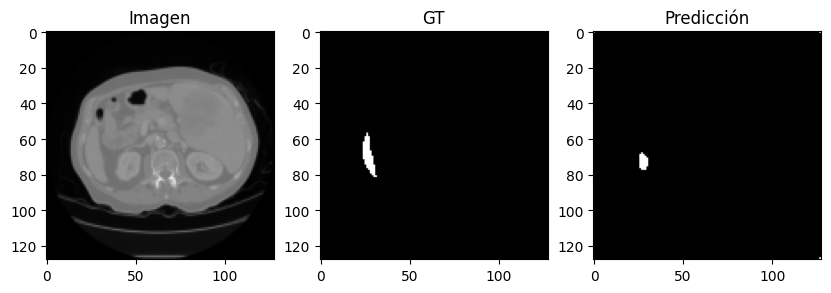

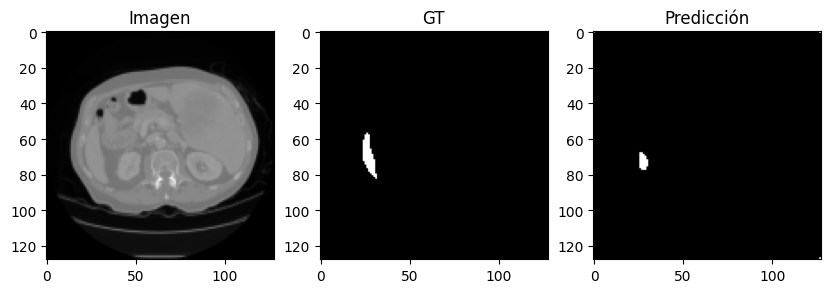

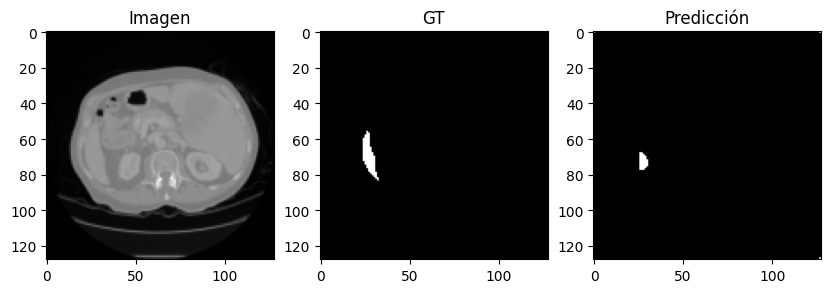

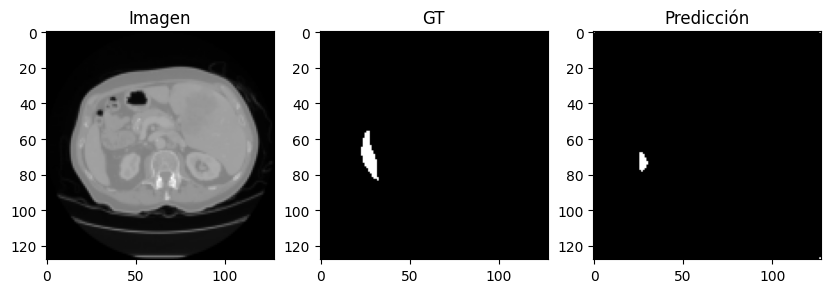

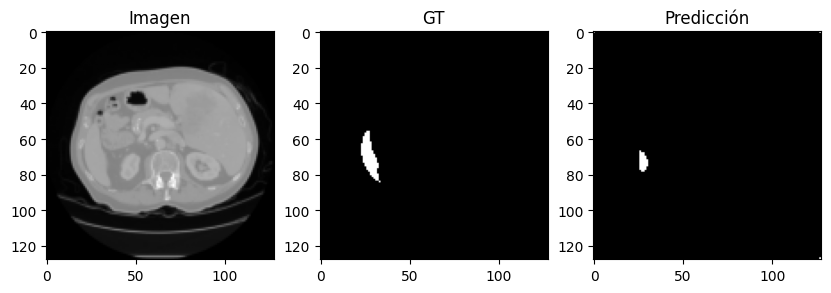

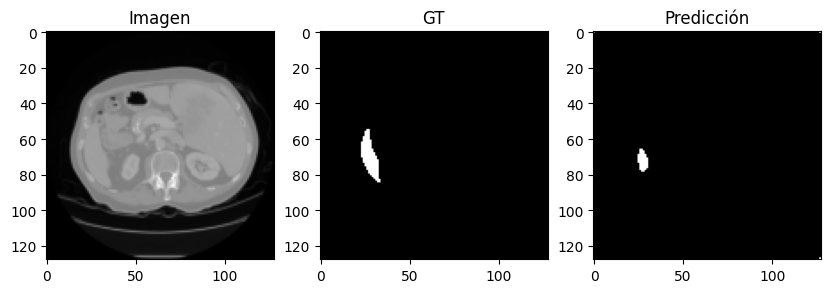

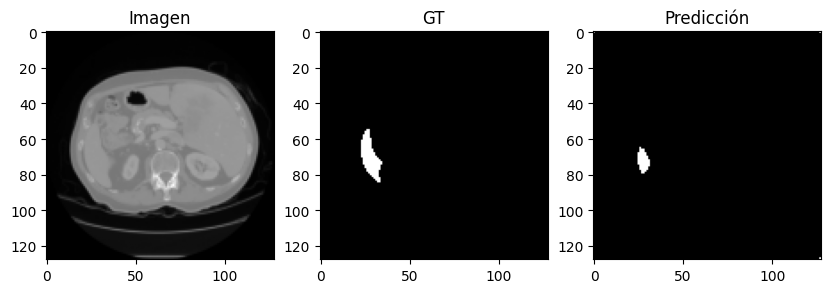

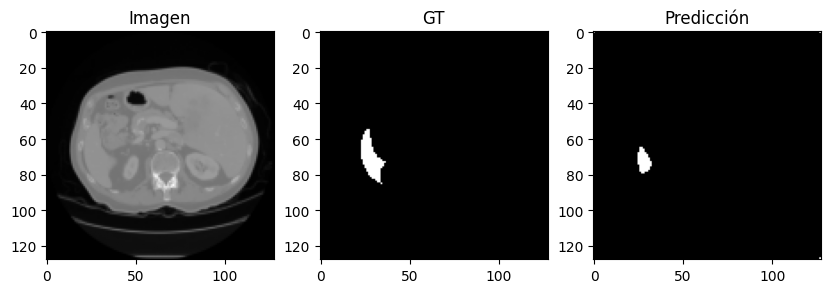

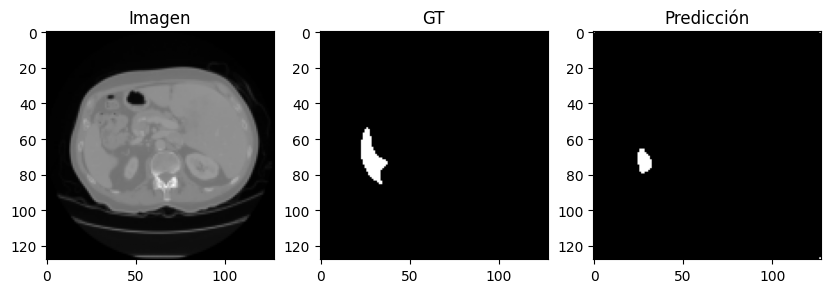

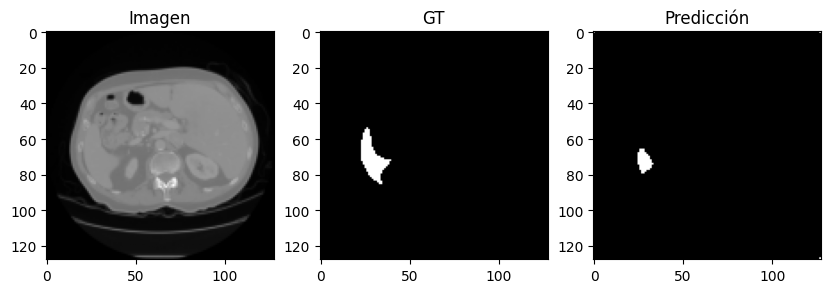

In [ ]:
# Visualization and evaluation
preds = model.predict(X_test[:10]) > 0.05  # NEW: Use 0.05 threshold based on class imbalance
for i in range(10):  
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(X_test[i].squeeze(), cmap='gray'); plt.title("Imagen")
    plt.subplot(1,3,2); plt.imshow(Y_test[i].squeeze(), cmap='gray'); plt.title("GT")
    plt.subplot(1,3,3); plt.imshow(preds[i].squeeze(), cmap='gray'); plt.title("Predicción")
    plt.show()

In [21]:
# NEW: Metrics calculation with optimal threshold
def dice_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    return (2 * intersection + 1e-6) / (union + 1e-6)

def iou_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# NEW: Use optimal threshold of 0.05 for final predictions (calculated based on several experimentations focusing on solve class imbalance)
optimal_threshold = 0.05
final_preds = (model.predict(X_test) > optimal_threshold).astype(np.uint8)

# Calculate final metrics
final_dices = [dice_np(Y_test[i], final_preds[i]) for i in range(len(final_preds))]
final_ious = [iou_np(Y_test[i], final_preds[i]) for i in range(len(final_preds))]

print(f"PERFORMANCE METRICS (threshold={optimal_threshold}):")
print(f"   • Average Dice Score: {np.mean(final_dices):.4f} ± {np.std(final_dices):.4f}")
print(f"   • Average IoU Score:  {np.mean(final_ious):.4f} ± {np.std(final_ious):.4f}")
print(f"   • Best Dice Score:    {np.max(final_dices):.4f}")
print(f"   • Worst Dice Score:   {np.min(final_dices):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
PERFORMANCE METRICS (threshold=0.05):
   • Average Dice Score: 0.4996 ± 0.0432
   • Average IoU Score:  0.3341 ± 0.0376
   • Best Dice Score:    0.5567
   • Worst Dice Score:   0.4088
